<a href="https://colab.research.google.com/github/DavidF2714/TC3006C/blob/main/A1_CV_Basic_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
!rm -rf DL_Data_sets/
!git clone --branch images https://github.com/octavio-navarro/DL_Data_sets.git

Cloning into 'DL_Data_sets'...
remote: Enumerating objects: 64969, done.
remote: Counting objects: 100% (500/500), done.
remote: Compressing objects: 100% (491/491), done.
remote: Total 64969 (delta 13), reused 493 (delta 9), pack-reused 64469 (from 1)
Receiving objects: 100% (64969/64969), 1.54 GiB | 34.83 MiB/s, done.
Resolving deltas: 100% (136/136), done.


# Day and Night Image Classifier
---

The day/night image dataset consists of 200 RGB color images in two categories: day and night. There are equal numbers of each example: 100 day images and 100 night images.

We'd like to build a classifier that can accurately label these images as day or night, and that relies on finding distinguishing features between the two types of images.

*Note: All images come from the [AMOS dataset](https://mvrl.cse.wustl.edu/datasets/amos/) (Archive of Many Outdoor Scenes).*


### Import resources

Before you get started on the project code, import the libraries and resources that you'll need.

In [122]:
import cv2
import os, glob

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Training and Testing Data
The 200 day/night images are separated into training and testing datasets.

* 60% of these images are training images, for you to use as you create a classifier.
* 40% are test images, which will be used to test the accuracy of your classifier.

First, we set some variables to keep track of some where our images are stored:

    image_dir_training: the directory where our training image data is stored
    image_dir_test: the directory where our test image data is stored

In [123]:
# Image data directories
image_dir_training = "/content/DL_Data_sets/images/day_night_images/training/"
image_dir_test = "/content/DL_Data_sets/images/day_night_images/test/"

## Load the datasets

These first few lines of code will load the training day/night images and store all of them in a variable, `IMAGE_LIST`. This list contains the images and their associated label ("day" or "night").

This function loads in images and their labels and places them in a list. The list contains all images and their associated labels. For example, after data is loaded, im_list[0][:] will be the first image-label pair in the list

In [124]:
def load_dataset(image_dir):

    # Populate this empty image list
    im_list = []
    image_types = ["day", "night"]

    # Iterate through each folder
    for im_type in image_types:

        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*")):

            # Read in the image
            im = cv2.imread(file)

            # Check if the image exists/if it's been correctly read-in
            if not im is None:
                # Append the image, and it's type to the image list
                im_list.append((im, im_type))

    return im_list

For example, the first image-label pair in `IMAGE_LIST` can be accessed by index:
``` IMAGE_LIST[0][:]```.

In [125]:
# Load training data
IMAGE_LIST = load_dataset(image_dir_training)

## Visualize sample day and night images

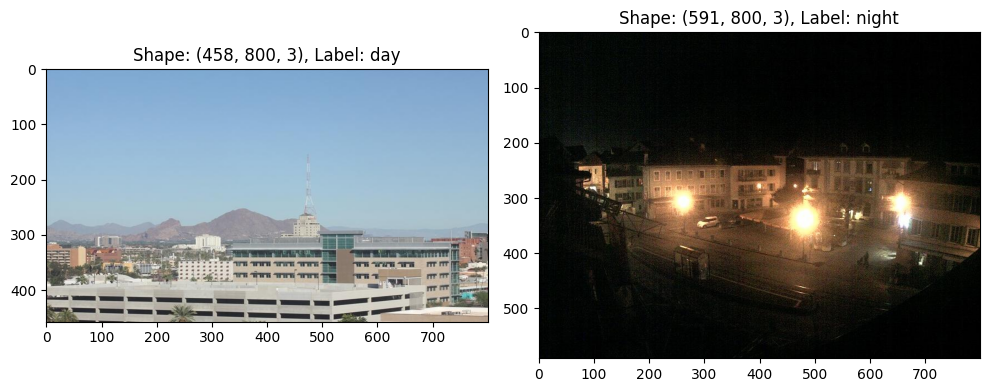

In [126]:
# Find indices of a day and night image
day_index = 0  # Initialize with the first image, assume it's day
night_index = 0
for i in range(len(IMAGE_LIST)):
    if IMAGE_LIST[i][1] == "night":  # If label is "night"
        night_index = i  # Store the index
        break  # Exit the loop after finding a night image

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed

# Display the day image on the left subplot
axes[0].imshow(cv2.cvtColor(IMAGE_LIST[day_index][0], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
axes[0].set_title(f"Shape: {IMAGE_LIST[day_index][0].shape}, Label: {IMAGE_LIST[day_index][1]}")

# Display the night image on the right subplot
axes[1].imshow(cv2.cvtColor(IMAGE_LIST[night_index][0], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
axes[1].set_title(f"Shape: {IMAGE_LIST[night_index][0].shape}, Label: {IMAGE_LIST[night_index][1]}")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the subplot

## Construct a `STANDARDIZED_LIST` of input images and output labels.

This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and numerical labels.

In [127]:
def standardize(image_list):
    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Resize the image to 600x1100px with cv2.resize
        resized_image = cv2.resize(image, (1100, 600))

        # Create numerical label (1 for day, 0 for night)
        numerical_label = 1 if label == "day" else 0

        # Append to the standardized list
        standard_list.append((resized_image, numerical_label))

    return standard_list

In [128]:
# Standardize all training images

STANDARDIZED_LIST = standardize(IMAGE_LIST)


## Visualize the standardized data

Display a standardized image from STANDARDIZED_LIST.

Shape: ((600, 1100, 3))
Label [1 = day, 0 = night]: 0


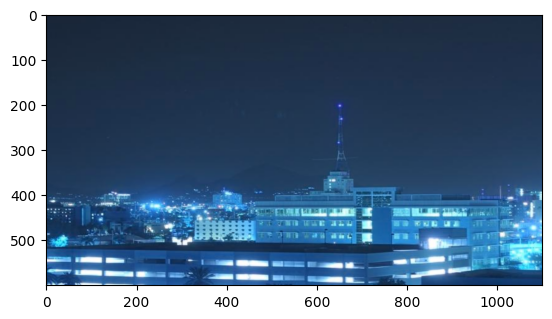

In [129]:
# Display a standardized image and its label

# Select an image by index
image_num = 160
selected_image = STANDARDIZED_LIST[image_num][0]
selected_label = STANDARDIZED_LIST[image_num][1]

# Display image and data about it
plt.imshow(selected_image)
print(f"Shape: ({selected_image.shape})")
print(f"Label [1 = day, 0 = night]: {selected_label}")

# Feature Extraction
---

Create a feature that best represents a day or night image. Preprocess the image as you see fit.


In [130]:
def feature_extraction_rgb_hsv_spatial(image, grid_size=(2, 2)):
    # Get image dimensions
    height, width, _ = image.shape

    # Global RGB mean
    avg_rgb_global = np.mean(image, axis=(0, 1))

    # Transform RGB to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    avg_hsv_global = np.mean(hsv_image, axis=(0, 1))  # Global HSV mean

    spatial_features = []  # To store local features (by grid blocks)

    # Define the size of each grid block
    grid_height = height // grid_size[0]
    grid_width = width // grid_size[1]

    # Divide the image into blocks and calculate the average for each block (in both RGB and HSV)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Region of interest (ROI) block in RGB
            roi_rgb = image[i * grid_height:(i + 1) * grid_height, j * grid_width:(j + 1) * grid_width]
            avg_rgb_local = np.mean(roi_rgb, axis=(0, 1))  # Local mean of R, G, B
            spatial_features.extend(avg_rgb_local)

            # Region of interest (ROI) block in HSV
            roi_hsv = hsv_image[i * grid_height:(i + 1) * grid_height, j * grid_width:(j + 1) * grid_width]
            avg_hsv_local = np.mean(roi_hsv, axis=(0, 1))  # Local mean of H, S, V
            spatial_features.extend(avg_hsv_local)

    # Combine all features: global RGB, global HSV, and spatial features
    features = np.concatenate([avg_rgb_global, avg_hsv_global, spatial_features])

    return features


# Classification and Visualizing Error

In this section, we'll turn feature into a classifier that takes in a standardized image and returns a `predicted_label` for that image. This `estimate_label` function should return a value: 0 or 1 (night or day, respectively).

---
### Build a complete classifier

Propose a classifier, and use it to create a model that classifies images into night and day. Include metrics that evaluate the performance of your model.

In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# STANDARDIZED_LIST contains your training set (images and labels)
features = [feature_extraction_rgb_hsv_spatial(image, grid_size=(2, 2)) for image, label in STANDARDIZED_LIST]
labels = [label for image, label in STANDARDIZED_LIST]

# Convert the features to a numpy array for training
features = np.array(features)

# Training with KNN (k=2 is a common starting value)
knn = KNeighborsClassifier(n_neighbors=2)

# Fit the model with the features and true labels from the training set
knn.fit(features, labels)


KNeighborsClassifier(n_neighbors=2)

## Testing the classifier

Here is where we test your classification algorithm using our test set of data that we set aside at the beginning of the notebook.

### Test dataset

Below, we load in the test dataset, standardize it using the `standardize` function you defined above, and then **shuffle** it; this ensures that order will not play a role in testing accuracy.


In [132]:
import random

# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = load_dataset(image_dir_test)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

Test your model on all the images from the test data. Add all the misclassified images to a new list.

In [134]:
from sklearn.metrics import accuracy_score

# Extract test features and true labels
test_features = [feature_extraction_rgb_hsv_spatial(image, grid_size=(2, 2)) for image, label in STANDARDIZED_TEST_LIST]
test_labels = [label for image, label in STANDARDIZED_TEST_LIST]

# Convert the features to a numpy array
test_features = np.array(test_features)

# Predict labels using the KNN model
predicted_test_labels = knn.predict(test_features)

# Evaluate the model's performance on the test set
accuracy = accuracy_score(test_labels, predicted_test_labels)
# Calculate the number of correct predictions
num_correct_predictions = np.sum(predicted_test_labels == test_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Number of correct predictions: {num_correct_predictions} / {len(test_labels)}")


Accuracy: 0.97
Número de predicciones correctas: 156 / 160


---
### Visualize the misclassified images

Visualize some of the images you classified wrong (in the `MISCLASSIFIED` list) and note any qualities that make them difficult to classify.

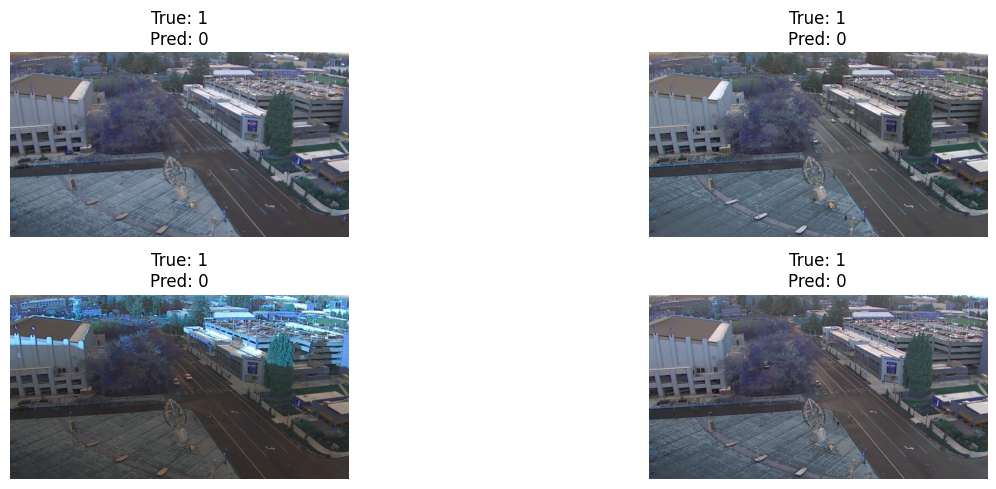

In [135]:
# Identify incorrectly predicted images
incorrect_indices = np.where(test_labels != predicted_test_labels)[0]

# Number of images to display
num_images_to_show = min(10, len(incorrect_indices))

# Create a figure to show the incorrect images
plt.figure(figsize=(15, 5))
for i in range(num_images_to_show):
    idx = incorrect_indices[i]
    image = STANDARDIZED_TEST_LIST[idx][0]  # Get the image
    true_label = test_labels[idx]  # True label
    predicted_label = predicted_test_labels[idx]  # Predicted label

    plt.subplot(2, num_images_to_show // 2, i + 1)
    plt.imshow(image)  # Display the image
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


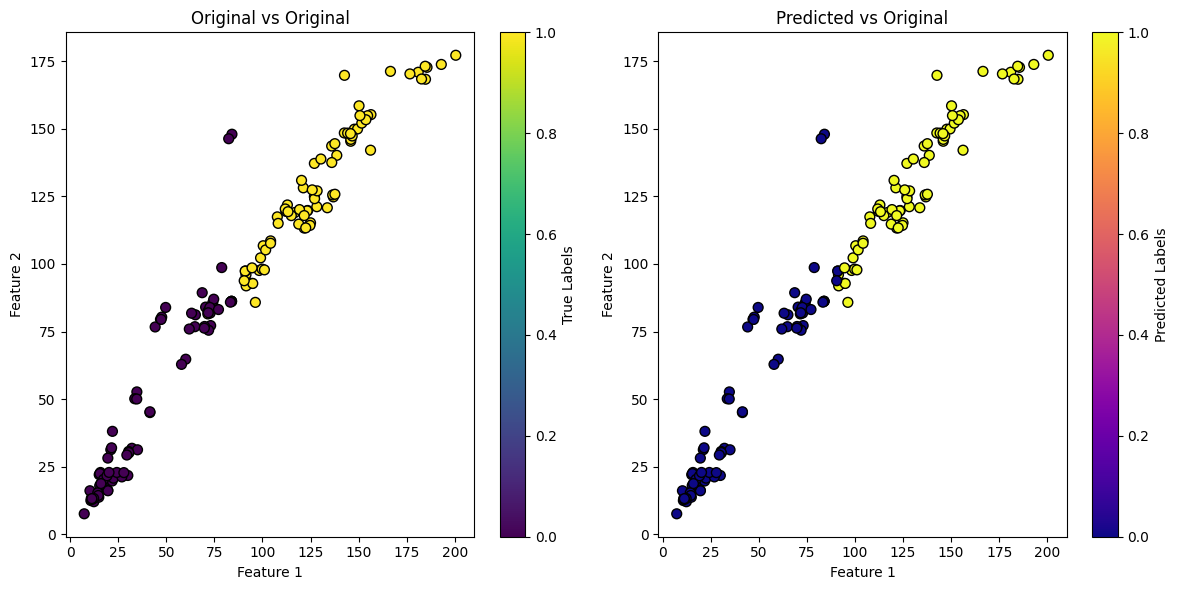

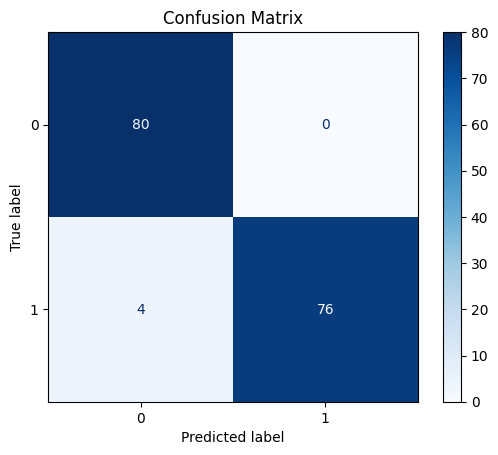

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming the features are in RGB
# Use only the first two features for the scatter plots
original_features = test_features[:, :2]

# Original vs Original scatter plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(original_features[:, 0], original_features[:, 1], c=test_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('Original vs Original')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='True Labels')

# Predicted vs Original scatter plot
predicted_features = test_features[:, :2]  # Use the same features for comparison
plt.subplot(1, 2, 2)
plt.scatter(predicted_features[:, 0], predicted_features[:, 1], c=predicted_test_labels, cmap='plasma', edgecolor='k', s=50)
plt.title('Predicted vs Original')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Labels')

plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(test_labels, predicted_test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# Conclusions
For this project, I've decided to use a KNN approach since there are only two categories. At first, I thought KNN would be a good algorithm for this task as it's effective at identifying categories that are quite different.

Let’s imagine a day vs. night image comparison. A human would easily recognize the difference between the images due to the illumination, brightness, and hues. Therefore, I thought if KNN could identify two images that don't share any similarities at all, then every other image that shares similar characteristics with those two initially identified would belong to the same group, which is basically how KNN works.

However, when testing the model, I realized there was a mismatch with four images. Upon debugging, I found that the issue was in how the model was interpreting the features.

To differentiate between day and night photos, I calculated the mean values for both HSV and RGB. When comparing those values with what the model considered day and night, I found that these four images were being misclassified as night, as their mean values were closer to what the model identified as night, as seen in the scatter plot.

We tested several approaches to improve accuracy by experimenting with different combinations of features. Initially, I used a combination of global RGB, global HSV, and local features using a 2x2 grid. This combination performed the best, providing an accuracy of 97%. When testing a larger set of features, such as including histograms and edge detection, the accuracy dropped to 86%. However, using only the global RGB, global HSV, and luminance gave a solid accuracy of 96%, proving to be an efficient balance between simplicity and performance.
